## Introducción a pre-trained models, transfer learning and fine tuning

```
Última actualización 04/08/2025
```



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_3a_Introduccion_transfer_learning_finetuning.ipynb)

In [39]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras import backend as K
from IPython.display import clear_output

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path

from matplotlib import cm
import matplotlib.cm as mpl_cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear


clear_output()

print("Se han importado todas las librerías correctamente")

Se han importado todas las librerías correctamente


In [40]:
#@title Definir funciones complementarias
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_curvas(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

def plot_matriz_confusion(cm, tipo_modelo, labels=None):
    if labels is None:
        labels = list(range(cm.shape[0]))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title(f'Matriz de Confusión – {tipo_modelo}')
    plt.tight_layout()
    plt.show()

def show_images(image_titles, images, cmap='viridis'):
    f, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(4*len(images), 4))
    for i, title in enumerate(image_titles):
        ax[i].set_title(title, fontsize=12)
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].axis('off')
    plt.tight_layout(); plt.show()

def show_images_with_heatmap(image_titles, images, cams, cmap='jet'):
    f, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(4*len(images), 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.get_cmap(cmap)(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=12)
        ax[i].imshow(images[i].astype("uint8"))
        ax[i].imshow(heatmap, alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout(); plt.show()



## Transfer Learning y fine tuning en Clasificación de imágenes

In [63]:
DATA_DIR = Path(r"C:\Users\User\Desktop\Deep Learning\images_processed")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE


# Split train/val (20%). Luego partimos val en val/test al 50/50.
train_ds = tf.keras.utils.image_dataset_from_directory(
DATA_DIR,
image_size=IMG_SIZE, batch_size=BATCH_SIZE,
color_mode="rgb",
label_mode="categorical",
validation_split=0.2, subset="training", seed=SEED
)
valtest_ds = tf.keras.utils.image_dataset_from_directory(
DATA_DIR,
image_size=IMG_SIZE, batch_size=BATCH_SIZE,
color_mode="rgb",
label_mode="categorical",
validation_split=0.2, subset="validation", seed=SEED
)


class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)


# Partimos val/test
valtest_cards = tf.data.experimental.cardinality(valtest_ds)
test_ds = valtest_ds.take(valtest_cards // 2)
val_ds = valtest_ds.skip(valtest_cards // 2)


train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)



Found 4072 files belonging to 3 classes.
Using 3258 files for training.
Found 4072 files belonging to 3 classes.
Using 814 files for validation.
Clases: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [64]:
# === Modelo TL (EfficientNetB0) ===
efn_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efn_base.trainable = False


inputs = tf.keras.Input(shape=(224, 224, 3))
x = efn_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
train_ds, validation_data=val_ds, epochs=20,
callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)


test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy en test: {test_acc:.4f}")

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 89s 794ms/step - accuracy: 0.7702 - loss: 0.5802 - val_accuracy: 0.9045 - val_loss: 0.2884
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 650ms/step - accuracy: 0.8826 - loss: 0.3285 - val_accuracy: 0.9196 - val_loss: 0.2452
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 649ms/step - accuracy: 0.8991 - loss: 0.2810 - val_accuracy: 0.9246 - val_loss: 0.2192
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 659ms/step - accuracy: 0.9142 - loss: 0.2483 - val_accuracy: 0.9322 - val_loss: 0.2007
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 660ms/step - accuracy: 0.9151 - loss: 0.2377 - val_accuracy: 0.9296 - val_loss: 0.1906
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 648ms/step - accuracy: 0.9213 - loss: 0.2163 - val_accuracy: 0.9347 - val_loss: 0.1867
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 645ms/step - accuracy: 0.9306 - loss: 0.2055 - val_accuracy: 0.9347 - val_loss: 0.1842
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 649ms/step - accuracy: 0.9281 - loss: 0

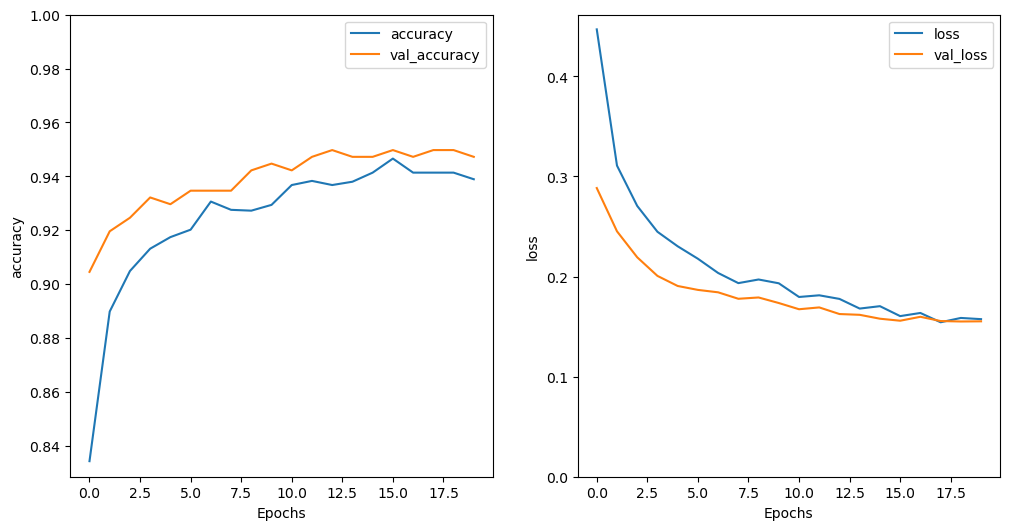

In [65]:
plot_curvas(history) 

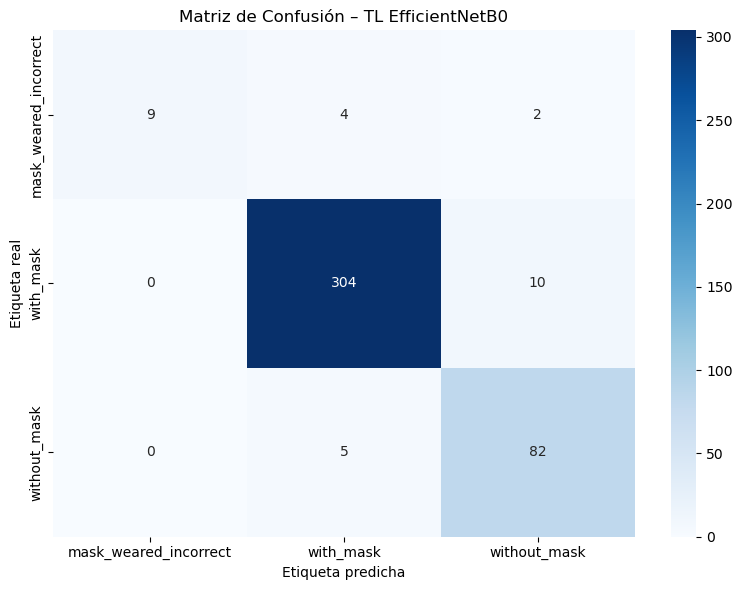

Accuracy (test): 0.9495192307692307
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.60      0.75        15
            with_mask       0.97      0.97      0.97       314
         without_mask       0.87      0.94      0.91        87

             accuracy                           0.95       416
            macro avg       0.95      0.84      0.88       416
         weighted avg       0.95      0.95      0.95       416



In [66]:

# 1) Predicciones y etiquetas reales (una sola pasada)
probs = model.predict(test_ds, verbose=0)             # (N, K)
y_pred = probs.argmax(axis=1)

y_true_oh = np.concatenate([y.numpy() for _, y in test_ds], axis=0)  # one-hot
y_true = y_true_oh.argmax(axis=1)

# 2) Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plot_matriz_confusion(cm, "TL EfficientNetB0", class_names)

# 3) Métricas
print("Accuracy (test):", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


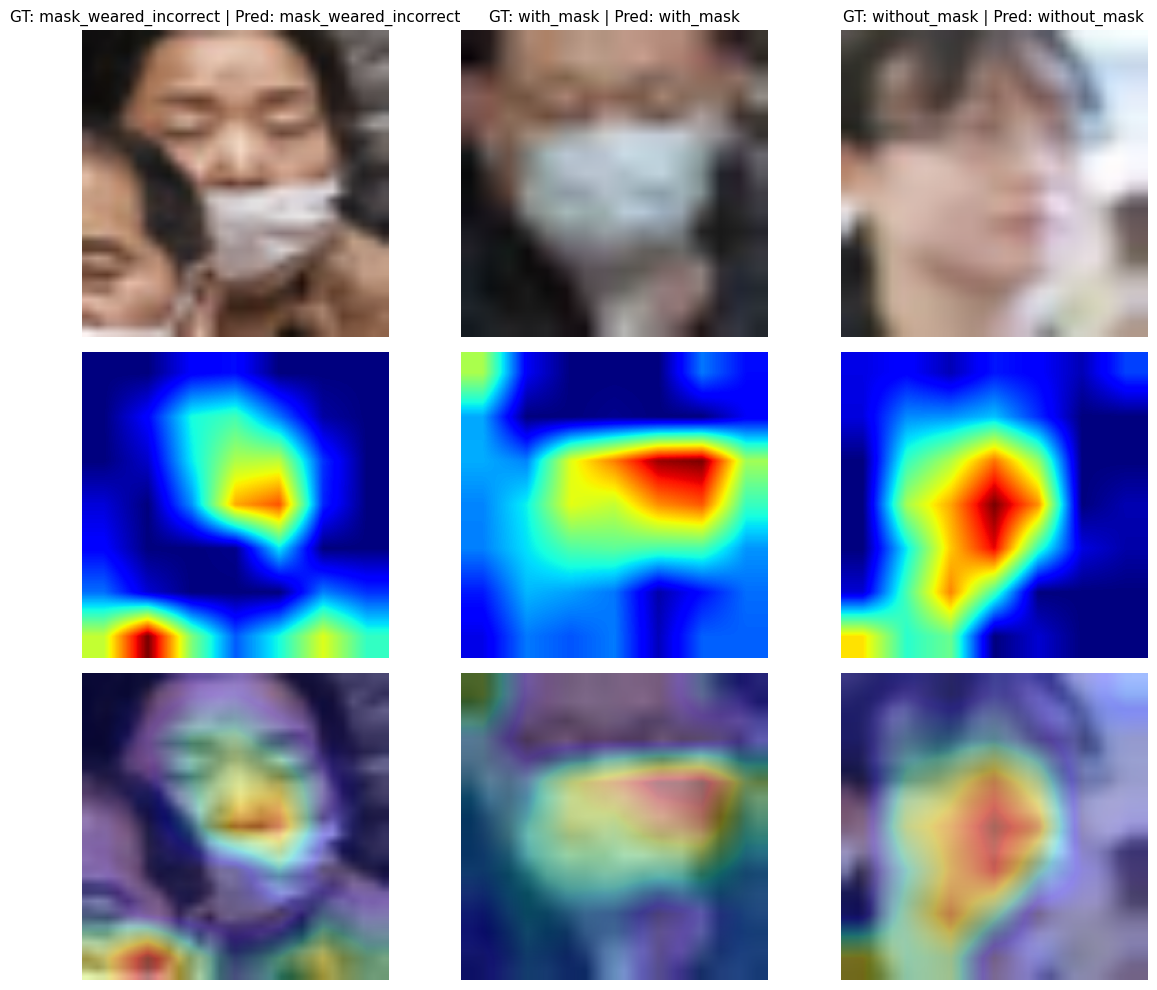

In [67]:
# --- Submodelo: features pre-GAP + SALIDA SOFTMAX (K clases) ---
gap = next(l for l in model.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
feat_t  = gap.input                 # (B,H,W,C)
probs_t = model.output              # (B,K)  <- importante: no uses .layers[-1].input
feat_pred = tf.keras.Model(model.inputs, [feat_t, probs_t])

# --- Grad-CAM sobre un batch (explica la clase predicha por softmax) ---
def gradcam_batch(x, class_idx=None, out_size=(224,224)):
    x = tf.cast(x, tf.float32)
    with tf.GradientTape() as t:
        F, probs = feat_pred(x, training=False)              # (N,H,W,C),(N,K)
        if class_idx is None:
            class_idx = tf.argmax(probs, axis=1)
        class_idx = tf.cast(class_idx, tf.int32)
        idx = tf.stack([tf.range(tf.shape(probs)[0], dtype=tf.int32), class_idx], axis=1)
        score = tf.gather_nd(probs, idx)                     # (N,)
    g = t.gradient(score, F)
    w = tf.reduce_mean(g, axis=(1,2), keepdims=True)
    cam = tf.nn.relu(tf.reduce_sum(w * F, axis=-1))          # (N,H,W)
    cam = (cam - tf.reduce_min(cam, (1,2), True)) / (tf.reduce_max(cam, (1,2), True) + 1e-8)
    cam = tf.image.resize(cam[...,None], out_size)[...,0]
    return cam.numpy(), probs.numpy()

# --- 1 muestra por clase (orden 0..K-1) ---
def one_per_class(ds, k):
    got=[False]*k; imgs=[None]*k; y=[None]*k
    for x, yy in ds.unbatch():
        i=int(tf.argmax(yy)); 
        if not got[i]: imgs[i]=x.numpy(); y[i]=i; got[i]=True
        if all(got): break
    return np.stack(imgs), np.array(y, np.int32)

K = len(class_names)
imgs, y_true = one_per_class(test_ds, K)
cams, probs  = gradcam_batch(imgs, out_size=(224,224))

# chequeo rápido
assert probs.shape[1] == K, f"Esperaba K={K} columnas en probs, obtuve {probs.shape[1]}"

pred_idx = np.argmax(probs, axis=1)
id2name = {i:n for i,n in enumerate(class_names)}
titles = [f"GT: {id2name.get(int(gt),'?')} | Pred: {id2name.get(int(p),'?')}"
          for gt,p in zip(y_true, pred_idx)]

# Visual
def show_triptych(imgs, cams, titles, cmap='jet', alpha=0.35):
    n=len(imgs); C=mpl.colormaps[cmap]
    plt.figure(figsize=(4*n,10))
    for i in range(n):
        img=imgs[i].astype('uint8'); heat=(C(cams[i])[...,:3]*255).astype('uint8')
        ax=plt.subplot(3,n,i+1);     ax.set_title(titles[i],fontsize=11); ax.imshow(img); ax.axis('off')
        ax=plt.subplot(3,n,n+i+1);   ax.imshow(cams[i],cmap=cmap);        ax.axis('off')
        ax=plt.subplot(3,n,2*n+i+1); ax.imshow(img); ax.imshow(heat,alpha=alpha); ax.axis('off')
    plt.tight_layout(); plt.show()

show_triptych(imgs, cams, titles)